# Homework 5

In [15]:
import os
import pdb
import torch
import random
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import tensorflow as tf
import torch.optim as optim
import tensorflow_hub as tfhub
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from torchsummary import summary
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler

import warnings
warnings.filterwarnings('ignore')

In [16]:
# This is for reproducibility
def set_seed(seed_value):
    pl.seed_everything(seed_value)

Files already downloaded and verified
Files already downloaded and verified
Train size: (50000, 32, 32, 3)
Test size: (10000, 32, 32, 3)
mean: [0.49139968 0.48215841 0.44653091]
std: [0.24703223 0.24348513 0.26158784]
Image size: torch.Size([3, 32, 32])


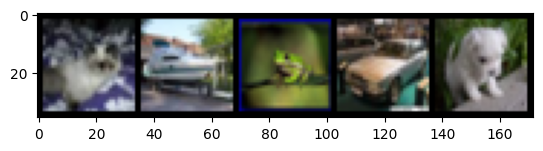

cat ship frog car dog


In [17]:
cifar_train = datasets.CIFAR10(root='./datasets', train=True, download=True, transform=transforms.ToTensor())
cifar_test = datasets.CIFAR10(root='./datasets', train=False, download=True, transform=transforms.ToTensor())
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Train size: {cifar_train.data.shape}")
print(f"Test size: {cifar_test.data.shape}")
print("mean:", cifar_train.data.mean(axis=(0, 1, 2)) / 255)
print("std:", cifar_train.data.std(axis=(0, 1, 2)) / 255)

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

trainloader = DataLoader(cifar_train, batch_size=5, shuffle=True, num_workers=2)

dataiter = iter(trainloader)
images, labels = next(dataiter)
print(f"Image size: {images[0].shape}")

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]}' for j in range(5)))

In [18]:
BATCH_SIZE = 128 if torch.cuda.is_available() else 64
NUM_WORKERS = int(os.cpu_count() / 4)
EPOCHS = 30
set_seed(85)

Global seed set to 85


In [19]:
class MyCNN(nn.Module):
    def __init__(self, n_classes):
        super(MyCNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(2, 2))
        
        self.fc = nn.Sequential(
            nn.Linear(512 * 2 * 2, 1024),
            nn.ReLU(),
            nn.Linear(1024, n_classes)
        )
        
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, input):
        x = input
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        x = self.dropout(x)
        
        x = self.avgpool(x)
        
        x = torch.flatten(x, 1)
        
        out = self.fc(x)
        
        return out

def ResNet(n_classes):
    resnet18 = torchvision.models.resnet18(pretrained=False, num_classes=n_classes)
    resnet18.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
    resnet18.maxpool = nn.Identity()
    return resnet18

In [20]:
class ImageClassifier(pl.LightningModule):
    def __init__(self, model, use_resnet=False, len_cifar_train=50000, augmentation=False) -> None:
        super(ImageClassifier, self).__init__()
        
        self.model = model
        self.criterion = nn.CrossEntropyLoss()
        
        self.augmentation = augmentation
        
        indices = list(range(len_cifar_train))
        split = int(np.floor(len_cifar_train * 0.1))
        np.random.shuffle(indices)
        
        self.train_idx, self.val_idx = indices[split:], indices[:split]
        
    def train_dataloader(self):
        if self.augmentation:
            transformations = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616)),
            ])
        else:
            transformations = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616))
            ])
        
        train_dataset = datasets.CIFAR10(root='./datasets', train=True, transform=transformations)
        train_sampler = SubsetRandomSampler(self.train_idx)
        train_loader = DataLoader(
            train_dataset,
            batch_size=BATCH_SIZE,
            sampler=train_sampler,
            num_workers=NUM_WORKERS,
            pin_memory=True
        )
        return train_loader

    def val_dataloader(self):
        transformations = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616))
        ])
        
        val_dataset = datasets.CIFAR10(root='./datasets', train=True, transform=transformations)
        val_sampler = SubsetRandomSampler(self.val_idx)
        val_loader = DataLoader(
            val_dataset,
            batch_size=BATCH_SIZE,
            sampler=val_sampler,
            num_workers=NUM_WORKERS,
            pin_memory=True
        )
        return val_loader

    def test_dataloader(self):
        transformations = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616))
        ])
        
        test_dataset = datasets.CIFAR10(root='./datasets', train=False, transform=transformations)
        test_loader = DataLoader(
            test_dataset,
            batch_size=BATCH_SIZE,
            num_workers=NUM_WORKERS,
            pin_memory=True
        )
        return test_loader
    
    def training_step(self, batch, batch_idx):
        images, labels = batch
        output = self.model(images)
        
        loss = self.criterion(output, labels)
        self.log('train_loss', loss, on_step=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch
        
        output = self.model(images)
        
        val_loss = self.criterion(output, labels)
        
        preds = output.argmax(dim=1, keepdim=True)
        corrects = preds.eq(labels.view_as(preds)).sum().item()
        accuracy = corrects / len(batch)
        
        result = {'val_loss': val_loss, 'corrects': corrects, 'num_labels': labels.shape[0]}
        self.log('val_loss', val_loss)
        return result

    def validation_epoch_end(self, outputs):
        val_losses = [output['val_loss'].item() for output in outputs]
        corrects = [output['corrects'] for output in outputs]
        num_labels = [output['num_labels'] for output in outputs]
        val_acc = np.sum(corrects) / np.sum(num_labels)
        
        self.log('val_loss_epoch', np.mean(val_losses), on_epoch=True, prog_bar=True)
        self.log('val_accuracy', val_acc, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        images, labels = batch
        
        output = self.model(images)
        
        test_loss = self.criterion(output, labels)
        
        preds = output.argmax(dim=1, keepdim=True)
        corrects = preds.eq(labels.view_as(preds)).sum().item()
        
        result = {'test_loss': test_loss, 'corrects': corrects, 'num_labels': preds.shape[0]}
        return result

    def test_epoch_end(self, outputs) -> None:
        test_losses = [output['test_loss'].item() for output in outputs]
        corrects = [output['corrects'] for output in outputs]
        num_labels = [output['num_labels'] for output in outputs]
        test_acc = np.sum(corrects) / np.sum(num_labels)
        
        self.log('test_loss', np.mean(test_losses))
        self.log('test_acc', test_acc)
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        scheduler = {
            "scheduler": StepLR(
                optimizer,
                step_size=10,
                gamma=0.1
            ),
            "interval": "epoch",
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

In [21]:
cnn = MyCNN(len(classes))
summary(cnn, (3, 32, 32), verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32, 32, 32]          --
|    └─Conv2d: 2-1                       [-1, 32, 32, 32]          896
|    └─BatchNorm2d: 2-2                  [-1, 32, 32, 32]          64
|    └─ReLU: 2-3                         [-1, 32, 32, 32]          --
├─Sequential: 1-2                        [-1, 64, 32, 32]          --
|    └─Conv2d: 2-4                       [-1, 64, 32, 32]          18,496
|    └─BatchNorm2d: 2-5                  [-1, 64, 32, 32]          128
|    └─ReLU: 2-6                         [-1, 64, 32, 32]          --
├─Sequential: 1-3                        [-1, 128, 32, 32]         --
|    └─Conv2d: 2-7                       [-1, 128, 32, 32]         73,856
|    └─BatchNorm2d: 2-8                  [-1, 128, 32, 32]         256
|    └─ReLU: 2-9                         [-1, 128, 32, 32]         --
├─Sequential: 1-4                        [-1, 256, 32, 32]         --
|   

In [22]:
image_classifier = ImageClassifier(model=cnn)
trainer = pl.Trainer(
    logger=pl_loggers.CSVLogger(
        save_dir='./models/cnn'
    ),
    callbacks=ModelCheckpoint(
        dirpath='./models/cnn',
        monitor='val_accuracy',
        filename='cifar10_{val_accuracy:.3f}',
        mode='max'
    ),
    gpus=1,
    max_epochs=EPOCHS,
)
trainer.fit(image_classifier)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | MyCNN            | 3.7 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.716    Total estimated model params size (MB)


Epoch 29: 100%|██████████| 392/392 [01:13<00:00,  5.35it/s, loss=0.0886, v_num=0, train_loss=0.0886, val_loss_epoch=0.453, val_accuracy=0.860]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 392/392 [01:13<00:00,  5.35it/s, loss=0.0886, v_num=0, train_loss=0.0886, val_loss_epoch=0.453, val_accuracy=0.860]


In [23]:
cnn_result = trainer.test(image_classifier)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 79/79 [00:02<00:00, 29.25it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                  0.8621
        test_loss           0.4560257336006889
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [24]:
resnet18 = ResNet(len(classes))
summary(resnet18, (3, 32, 32), verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 32, 32]          1,728
├─BatchNorm2d: 1-2                       [-1, 64, 32, 32]          128
├─ReLU: 1-3                              [-1, 64, 32, 32]          --
├─Identity: 1-4                          [-1, 64, 32, 32]          --
├─Sequential: 1-5                        [-1, 64, 32, 32]          --
|    └─BasicBlock: 2-1                   [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 32, 32]          36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-3                    [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 32, 32]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-6                    [-1, 64, 32, 32]          --
|    └─BasicBlock: 2-2                   [-1, 64, 32, 32]          --
|

In [25]:
image_classifier = ImageClassifier(model=resnet18, use_resnet=True)
trainer = pl.Trainer(
    logger=pl_loggers.CSVLogger(
        save_dir='./models/resnet18'
    ),
    callbacks=ModelCheckpoint(
        dirpath='./models/resnet18',
        monitor='val_accuracy',
        filename='cifar10_{val_accuracy:.3f}',
        mode='max'
    ),
    gpus=1,
    max_epochs=EPOCHS,
)
trainer.fit(image_classifier)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ResNet           | 11.2 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)


Epoch 29: 100%|██████████| 392/392 [00:44<00:00,  8.87it/s, loss=0.000396, v_num=0, train_loss=0.000367, val_loss_epoch=0.656, val_accuracy=0.865]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 392/392 [00:44<00:00,  8.87it/s, loss=0.000396, v_num=0, train_loss=0.000367, val_loss_epoch=0.656, val_accuracy=0.865]


In [26]:
resnet18_result = trainer.test(image_classifier)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 79/79 [00:01<00:00, 44.72it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                  0.8579
        test_loss           0.7055906940110123
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [27]:
cnn = MyCNN(len(classes))
image_classifier = ImageClassifier(model=cnn, augmentation=True)
trainer = pl.Trainer(
    logger=pl_loggers.CSVLogger(
        save_dir='./models/cnn_augmentation'
    ),
    callbacks=ModelCheckpoint(
        dirpath='./models/cnn_augmentation',
        monitor='val_accuracy',
        filename='cifar10_{val_accuracy:.3f}',
        mode='max'
    ),
    gpus=1,
    max_epochs=EPOCHS,
)
trainer.fit(image_classifier)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | MyCNN            | 3.7 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.716    Total estimated model params size (MB)


Epoch 29: 100%|██████████| 392/392 [01:13<00:00,  5.35it/s, loss=0.339, v_num=0, train_loss=0.392, val_loss_epoch=0.423, val_accuracy=0.855]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 392/392 [01:13<00:00,  5.35it/s, loss=0.339, v_num=0, train_loss=0.392, val_loss_epoch=0.423, val_accuracy=0.855]


In [28]:
cnn_augmentation_result = trainer.test(image_classifier)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 79/79 [00:02<00:00, 29.69it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                  0.8562
        test_loss           0.4254688760147819
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
